<a href="https://colab.research.google.com/github/the-Quert/inlpfun/blob/master/Lab/Demo/LSTM/lstm_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Mount GDrive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Migrate TF1 code to TF2

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


#### Data dowloading (IMDb)

In [0]:
!git clone https://github.com/adeshpande3/LSTM-Sentiment-Analysis.git

Cloning into 'LSTM-Sentiment-Analysis'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), done.


In [0]:
!tar xvzf /content/LSTM-Sentiment-Analysis/training_data.tar.gz

In [0]:
!tar xvzf /content/LSTM-Sentiment-Analysis/models.tar.gz

models/
models/pretrained_lstm.ckpt-90000.meta
models/pretrained_lstm.ckpt-90000.data-00000-of-00001
models/pretrained_lstm.ckpt-90000.index
models/checkpoint


In [0]:
'''
!rm -rf /content/negativeReviews
!rm -rf /content/positiveReviews
!rm -rf /content/idsMatrix.npy
!rm -rf /content/wordVectors.npy
!rm -rf /content/wordsList.npy
'''

#### Steps
- Training a word vector generation model (such as Word2Vec) or loading pretrained word vectors
- Creating an ID's matrix for our training set
- RNN (With LSTM units) graph creation
- Training 
- Testing

#### 1. Training a word vector generation model (such as GloVe) or loading pretrained word vectors.
- Pre-trained `GloVe` does more pre-process than `Word2Vec`.
- `Word2Vec` model contains 3 million word vectors, each with a dimensionality of 300.
- `GloVe` contains 400,000 word vectors, each with a dimensionality of 50.

In [0]:
import numpy as np
wordsList = np.load('/content/wordsList.npy')
print('Loaded the word list')
# Load as numpy array
wordsList = wordsList.tolist()
wordsList = [word.decode('UTF-8') for word in wordsList]
wordVectors = np.load('/content/wordVectors.npy')
print('Loaded the word vectors')

Loaded the word list
Loaded the word vectors


In [0]:
print(len(wordsList))
print(wordVectors.shape)
# Embedding matrix: [400000, 50]

400000
(400000, 50)


In [0]:
# Testing the index finding
import tensorflow as tf
max_seq_len = 10
num_of_dim = 50
id_matrix = np.zeros((max_seq_len), dtype = 'int32')
sentence_test = 'i thought the movie was incredible and inspiring'
sentence_test = sentence_test.split()
len_of_sentence = len(sentence_test)
for i in range(len_of_sentence):
    id_matrix[i] = wordsList.index(sentence_test[i])

print(id_matrix.shape)
print(id_matrix)


(10,)
[    41    804 201534   1005     15   7446      5  13767      0      0]


In [0]:
firstSentence = np.zeros((max_seq_len), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#firstSentence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

(10,)
[    41    804 201534   1005     15   7446      5  13767      0      0]


In [0]:
# Input sequence -> Integerized Representation -> Embedding Matrix ->
# tf.nn.embedding_lookup -> Sequence Vector
with tf.compat.v1.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors, firstSentence).eval().shape)

(10, 50)


In [0]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['positiveReviews/' + f for f in listdir('/content/positiveReviews/') if isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in listdir('/content/negativeReviews/') if isfile(join('negativeReviews/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, 'r', encoding = 'utf-8') as f:
        line = f.readline()
        counter = len(line.split())
        numWords.append(counter)
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, 'r', encoding = 'utf-8') as f:
        line = f.readline()
        counter = len(line.split())
        numWords.append(counter)
print('Negative files finished')

numFiles = len(numWords)
print('The totall number of files is {0}'.format(numFiles))
print('The total number of words in the files is {0}'.format(sum(numWords)))
print('The average number of words in the files is {0}'.format(sum(numWords) / len(numWords)))


Positive files finished
Negative files finished
The totall number of files is 25000
The total number of words in the files is 5844680
The average number of words in the files is 233.7872


(0.0, 1200.0, 0.0, 8000.0)

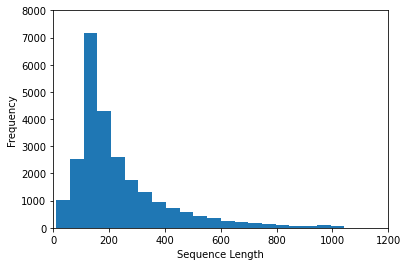

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])

In [0]:
max_seq_len = 250

In [0]:
# Removes punctuation, parentheses, question marks, etc., 
# and leaves only alphanumeric characters
# Convert sequence to an ids matrix
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

#### Creating an id matrix for our training set
#### [25000, 250]

In [0]:
'''
fname = positiveFiles[3] #Can use any valid index (not just 3)
with open(fname) as f:
    for lines in f:
        print(lines)
        exit
with open(fname) as f:
    indexCounter = 0
    line=f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        if indexCounter < max_seq_len:
            try:
                firstFile[indexCounter] = wordsList.index(word)
            except ValueError:
                firstFile[indexCounter] = 399999 #Vector for unknown words
        indexCounter = indexCounter + 1
firstFile
'''

In [0]:
ids = np.zeros((numFiles, max_seq_len), dtype='int32') # 25000, 250
fileCounter = 0
for pf in positiveFiles:
   with open(pf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= max_seq_len:
               break
       fileCounter = fileCounter + 1 

for nf in negativeFiles:
   with open(nf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
       fileCounter = fileCounter + 1 
# Pass into embedding function and see if it evaluates. 

np.save('idsMatrix', ids)

In [0]:
ids = np.load('idsMatrix.npy')

In [0]:
# Helper Functions
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, max_seq_len])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, max_seq_len])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

#### RNN (With LSTM units) graph creation

In [0]:
# RNN Model
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 50000
num_of_dim = 50

In [0]:
# Create placeholder for input_data and labels
tf.compat.v1.reset_default_graph()
input_data = tf.compat.v1.placeholder(tf.int32, [batchSize, max_seq_len])
labels = tf.compat.v1.placeholder(tf.float32, [batchSize, numClasses])

In [0]:
# Once we have out input_data's placeholder, we are going to call tf.nn.lookup()
# to get the word vectors.
# Return 3-D tensor : batchSize * max_seq_len * num_of_dim [24, 250, 50]
data = tf.Variable(tf.zeros([batchSize, max_seq_len, num_of_dim]), dtype = tf.float32)
data = tf.nn.embedding_lookup(wordVectors, input_data)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
print(data)

Tensor("embedding_lookup/Identity:0", shape=(24, 250, 50), dtype=float32)


In [0]:
# Create LSTM model
lstmCell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(lstmUnits)
lstmCell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
# unrolling the whole network and creating a pathway for the data to flow through the RNN graph.
value, _ = tf.compat.v1.nn.dynamic_rnn(cell=lstmCell, inputs=data, dtype=tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Weight initialization
weight = tf.Variable(tf.compat.v1.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape = [numClasses]))
value = tf.transpose(value, [1, 0, 2])
# Obtain the last value
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [0]:
correctPred = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [0]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.compat.v1.train.AdamOptimizer().minimize(loss)

In [0]:
import datetime
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.compat.v1.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.compat.v1.summary.FileWriter(logdir, sess.graph)

#### Training

In [0]:
!mkdir /content/drive/My\ Drive/LAB/models
sess = tf.compat.v1.InteractiveSession()
saver = tf.compat.v1.train.Saver()
sess.run(tf.compat.v1.global_variables_initializer())

for i in range(iterations):
   #Next Batch of reviews
   nextBatch, nextBatchLabels = getTrainBatch();
   sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})

   #Write summary to Tensorboard
   if (i % 100 == 0 and i != 0):
       summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
       writer.add_summary(summary, i)

   #Save the network every 10,000 training iterations
   if (i % 10000 == 0 and i != 0):
       save_path = saver.save(sess, "/content/drive/My Drive/LAB/models/pretrained_lstm.ckpt", global_step=i)
       print("saved to %s" % save_path)
writer.close()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


saved to /content/drive/My Drive/LAB/models/pretrained_lstm.ckpt-10000
saved to /content/drive/My Drive/LAB/models/pretrained_lstm.ckpt-20000
saved to /content/drive/My Drive/LAB/models/pretrained_lstm.ckpt-30000
saved to /content/drive/My Drive/LAB/models/pretrained_lstm.ckpt-40000


In [0]:
sess = tf.compat.v1.InteractiveSession()
saver = tf.compat.v1.train.Saver()
saver.restore(sess, tf.compat.v1.train.latest_checkpoint('/content/drive/My Drive/LAB/models'))

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/LAB/models/pretrained_lstm.ckpt-40000


#### Testing

In [0]:
iterations = 5000
store_res = []
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    res = ((sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)
    # print("Accuracy for this batch:", res)
    store_res.append(res)
sum(store_res) / len(store_res)

50.21416682898998